In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from tensorflow.keras.layers import Dense,Flatten,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import VGG16

In [ ]:
from tensorflow.keras.preprocessing import image
from skimage.transform import resize

In [ ]:
!wget nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget nc https://lazyprogrammer.me/course_files/bulbasaur-tight.png
!wget nc https://lazyprogrammer.me/course_files/squirtle-tight.png

--2023-02-22 16:37:29--  http://nc/
Resolving nc (nc)... failed: No address associated with hostname.
wget: unable to resolve host address ‘nc’
--2023-02-22 16:37:30--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png.1’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2023-02-22 16:37:30 (45.3 MB/s) - ‘charmander-tight.png.1’ saved [3952/3952]

FINISHED --2023-02-22 16:37:30--
Total wall clock time: 0.1s
Downloaded: 1 files, 3.9K in 0s (45.3 MB/s)
--2023-02-22 16:37:30--  http://nc/
Resolving nc (nc)... failed: No address associated with hostname.
wget: unable to resolve host address ‘nc’
--2023-02-22 16:37:30--  https://lazyprogrammer.

In [ ]:
!wget nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2023-02-22 16:37:31--  http://nc/
Resolving nc (nc)... failed: No address associated with hostname.
wget: unable to resolve host address ‘nc’
--2023-02-22 16:37:31--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip.1’

backgrounds.zip.1   100%[===================>] 482.42K  1.49MB/s    in 0.3s    

2023-02-22 16:37:31 (1.49 MB/s) - ‘backgrounds.zip.1’ saved [494000/494000]

FINISHED --2023-02-22 16:37:31--
Total wall clock time: 0.9s
Downloaded: 1 files, 482K in 0.3s (1.49 MB/s)


In [ ]:
!unzip backgrounds.zip

Archive:  backgrounds.zip
replace backgrounds/8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from glob import glob
backgrounds=[]
background_files=glob('backgrounds/*.jpg')
for f in background_files:
  bg=np.array(image.load_img(f))
  backgrounds.append(bg)

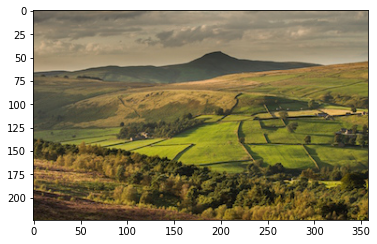

In [ ]:
plt.imshow(backgrounds[0])

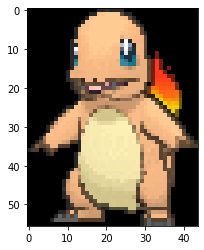

In [ ]:
ch=image.load_img('charmander-tight.png')
plt.imshow(ch)
plt.show()

In [ ]:
print(type(ch))
np.array(ch).shape

<class 'PIL.Image.Image'>


(56, 44, 3)

In [ ]:
from imageio import imread

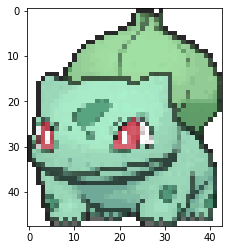

In [ ]:
ch=imread('charmander-tight.png')
bb=imread('bulbasaur-tight.png')
sq=imread('squirtle-tight.png')
plt.imshow(bb)

In [ ]:
type(ch)

imageio.core.util.Array

In [ ]:
ch.shape

(56, 44, 4)

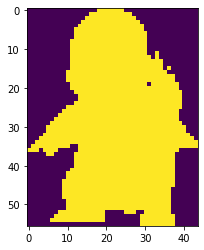

In [ ]:
plt.imshow(ch[:,:,3])
plt.show()

In [ ]:
POKE_DIM=200
ch=np.array(ch)
bb=np.array(bb)
sq=np.array(sq)
CH_H,CH_W,CH_C=ch.shape
BB_H,BB_W,BB_C=bb.shape
SQ_H,SQ_W,SQ_C=sq.shape

poke_dex=[
    [ch,CH_H,CH_W,CH_C],
    [bb,BB_H,BB_W,BB_C],
    [sq,SQ_H,SQ_W,SQ_C]
]

class_names=['Charmander','Bulbasaur','Squirtle']

In [ ]:
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy
def custom_loss(y_true,y_pred):
  bce=binary_crossentropy(y_true[:,:4],y_pred[:,:4])
  cce=categorical_crossentropy(y_true[:,4:7],y_pred[:,4:7])
  bce2=binary_crossentropy(y_true[:,-1],y_pred[:,-1])
  return bce *y_true[:,-1]+cce*y_true[:,-1]+0.5*bce2

In [ ]:
def pokemon_generator(batch_size=64):
  while True:
    for _ in range(50):
      X=np.zeros((batch_size,POKE_DIM,POKE_DIM,3))
      y=np.zeros((batch_size,8))
      for i in range(batch_size):
        bg_idx=np.random.choice(len(backgrounds))
        bg=backgrounds[bg_idx]
        bg_h,bg_w,_=bg.shape
        rnd_h=np.random.randint(bg_h-POKE_DIM)
        rnd_w=np.random.randint(bg_w-POKE_DIM)
        X[i]=bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()

        appear=(np.random.random()<0.75)

        if appear:
          poke_idx=np.random.choice(3)
          pk,h,w,_=poke_dex[poke_idx]  
          scale=0.5+np.random.random()
          new_height=int(h*scale)
          new_width=int(w*scale)
          obj=resize(pk,(new_height,new_width),preserve_range=True).astype(np.uint8)
          if np.random.random()<0.5:
            obj=np.fliplr(obj)   
          else:
            obj=obj
          row0=np.random.randint(POKE_DIM-new_height)
          col0=np.random.randint(POKE_DIM-new_width)
          row1=row0+new_height
          col1=col0+new_width
          mask=(obj[:,:,3]==0)
          bg_slice=X[i,row0:row1,col0:col1,:]
          bg_slice=np.expand_dims(mask,-1)*bg_slice
          bg_slice+=obj[:,:,:3]
          X[i,row0:row1,col0:col1,:]=bg_slice
          y[i,0]=row0/POKE_DIM
          y[i,1]=col0/POKE_DIM
          y[i,2]=(row1-row0)/POKE_DIM
          y[i,3]=(col1-col0)/POKE_DIM
          y[i,4+poke_idx]=1
        y[i,7]=appear
    yield X/255,y

In [ ]:
xx=None
yy=None
for x,y in pokemon_generator():
  xx,yy=x,y
  break

[0.75  0.475 0.19  0.17  0.    1.    0.    1.   ]


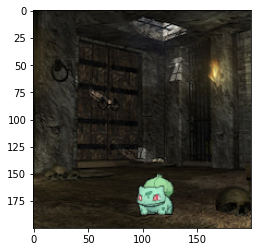

In [ ]:
n=yy.shape[0]
idx=np.random.randint(n)
plt.imshow(xx[idx])
print(yy[idx])

In [ ]:
vgg=VGG16(input_shape=(200,200,3),weights='imagenet',include_top=False)
x=Flatten()(vgg.output)
x1=Dense(4,activation='sigmoid')(x)
x2=Dense(3,activation='softmax')(x)
x3=Dense(1,activation='sigmoid')(x)
x=Concatenate()([x1,x2,x3])
model=Model(vgg.input,x)
model.compile(optimizer=Adam(learning_rate=0.0001),loss=custom_loss)

In [ ]:
model.fit_generator(pokemon_generator(),steps_per_epoch=50,epochs=5)

<ipython-input-29-97f01db1621f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(pokemon_generator(),steps_per_epoch=50,epochs=5)


Epoch 1/5
50/50 [==============================] - 5299s 106s/step - loss: 1.0054
Epoch 2/5


In [ ]:
from matplotlib.patches import Rectangle
def pokemon_prediction():
  bg_idx=np.random.choice(len(backgrounds))
  bg=backgrounds[bg_idx]
  bg_h,bg_w,_=bg.shape
  rnd_h=np.random.randint(bg_h-POKE_DIM)
  rnd_w=np.random.randint(bg_w-POKE_DIM)
  X=bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()

  appear=(np.random.random()<0.75)
  if appear:
    poke_idx=np.random.choice(3)
    pk,h,w,_=poke_dex[poke_idx]  
    scale=0.5+np.random.random()
    new_height=int(h*scale)
    new_width=int(w*scale)
    obj=resize(pk,(new_height,new_width),preserve_range=True).astype(np.uint8)
    if np.random.random()<0.5:
      obj=np.fliplr(obj)
    else:
      obj=obj        
    row0=np.random.randint(POKE_DIM-new_height)
    col0=np.random.randint(POKE_DIM-new_width)
    row1=row0+new_height
    col1=col0+new_width
    mask=(obj[:,:,3]==0)
    bg_slice=X[row0:row1,col0:col1,:]
    bg_slice=np.expand_dims(mask,-1)*bg_slice
    bg_slice+=obj[:,:,:3]
    X[row0:row1,col0:col1,:]=bg_slice
    X=np.expand_dims(X,0)/255
    p=model.predict(X)[0]

    fig,ax=plt.subplots(1)
    ax.imshow(X)
    if p[-1]>0.5:
      class_pred_idx=np.argmax(p[4:7])
      class_pred=class_names[class_pred_idx]
      print(class_pred)
      rect=Rectangle((p[1]*POKE_DIM,p[0]*POKE_DIM),p[3]*POKE_DIM,p[2]*POKE_DIM,edgecolor='r',facecolor='none')
      ax.add_patch(rect)
    else:
      print("pred: No object detected")
    plt.show()